In [2]:
# Import The Libraries

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
# Import The Dataset
df = pd.read_excel('resources/Online Retail.xlsx')
df = df[df['CustomerID'].notna()]

In [3]:
# Check for missing values
missing_values = df.isnull().sum()
print("Missing values:\n", missing_values)

df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
df.dtypes

Missing values:
 InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64


InvoiceNo              object
StockCode              object
Description            object
Quantity                int64
InvoiceDate    datetime64[ns]
UnitPrice             float64
CustomerID            float64
Country                object
dtype: object

In [4]:
summary_stats = df.describe()
print("Summary statistics:\n", summary_stats)


Summary statistics:
             Quantity                    InvoiceDate      UnitPrice  \
count  406829.000000                         406829  406829.000000   
mean       12.061303  2011-07-10 16:30:57.879207424       3.460471   
min    -80995.000000            2010-12-01 08:26:00       0.000000   
25%         2.000000            2011-04-06 15:02:00       1.250000   
50%         5.000000            2011-07-31 11:48:00       1.950000   
75%        12.000000            2011-10-20 13:06:00       3.750000   
max     80995.000000            2011-12-09 12:50:00   38970.000000   
std       248.693370                            NaN      69.315162   

          CustomerID  
count  406829.000000  
mean    15287.690570  
min     12346.000000  
25%     13953.000000  
50%     15152.000000  
75%     16791.000000  
max     18287.000000  
std      1713.600303  


In [5]:
df.columns

Index(['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'UnitPrice', 'CustomerID', 'Country'],
      dtype='object')

In [6]:
from datetime import datetime, timedelta  # Import timedelta directly from datetime module

# Convert 'InvoiceDate' column to datetime format
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

# Create 'TotalSum' column
df["TotalSum"] = df["Quantity"] * df["UnitPrice"]

# Create a snapshot date for recency calculation
snapshot_date = max(df['InvoiceDate']) + timedelta(days=1)  # Use timedelta directly


# Aggregate data by each customer
customers = df.groupby(['CustomerID']).agg({
    'InvoiceDate': lambda x: (snapshot_date - x.max()).days,
    'InvoiceNo': 'count',
    'TotalSum': 'sum'
})

# Rename columns
customers.rename(columns={'InvoiceDate': 'Recency',
                          'InvoiceNo': 'Frequency',
                          'TotalSum': 'MonetaryValue'}, inplace=True)

# Group by Country and CustomerID, and aggregate the data
combined_summary = df.groupby(['Country', 'CustomerID']).agg({
    'InvoiceNo': 'nunique',  # Number of unique invoices
    'Quantity': 'sum',        # Total quantity purchased
    'UnitPrice': 'mean',      # Average unit price
    'TotalSum': 'sum'         # Monetary value
}).reset_index()

# Rename the columns for clarity
combined_summary.columns = ['Country', 'CustomerID', 'TotalInvoices', 'TotalQuantity',
                            'AverageUnitPrice', 'MonetaryValue']

# Display the combined summarized dataset
combined_summary

,Country,CustomerID,TotalInvoices,TotalQuantity,AverageUnitPrice,MonetaryValue
0,Australia,12386.0,2,354,2.391000,401.90
1,Australia,12388.0,6,1462,2.777700,2780.66
2,Australia,12393.0,4,816,2.279688,1582.60
3,Australia,12415.0,26,77242,3.213136,123725.45
4,Australia,12422.0,2,195,2.434286,386.20
...,...,...,...,...,...,...
4375,United Kingdom,18287.0,3,1586,1.493571,1837.28
4376,Unspecified,12363.0,2,408,2.311739,552.00
4377,Unspecified,12743.0,2,319,3.038582,546.43
4378,Unspecified,14265.0,2,330,5.862903,530.18


In [7]:
# Group by Country and CustomerID, and aggregate the data
combined_summary = df.groupby(['Country', 'CustomerID']).agg({
    'InvoiceNo': 'nunique',  # Number of unique invoices
    'Quantity': 'sum',        # Total quantity purchased
    'UnitPrice': 'mean',      # Average unit price
    'InvoiceDate': lambda x: (snapshot_date - x.max()).days,  # Recency
    'TotalSum': 'sum'         # Monetary value
}).reset_index()

# Rename the columns for clarity
combined_summary.columns = ['Country', 'CustomerID', 'TotalInvoices', 'TotalQuantity', 
                            'AverageUnitPrice', 'Recency', 'MonetaryValue']

# Display the summarized dataset
combined_summary

,Country,CustomerID,TotalInvoices,TotalQuantity,AverageUnitPrice,Recency,MonetaryValue
0,Australia,12386.0,2,354,2.391000,338,401.90
1,Australia,12388.0,6,1462,2.777700,16,2780.66
2,Australia,12393.0,4,816,2.279688,72,1582.60
3,Australia,12415.0,26,77242,3.213136,24,123725.45
4,Australia,12422.0,2,195,2.434286,96,386.20
...,...,...,...,...,...,...,...
4375,United Kingdom,18287.0,3,1586,1.493571,43,1837.28
4376,Unspecified,12363.0,2,408,2.311739,110,552.00
4377,Unspecified,12743.0,2,319,3.038582,134,546.43
4378,Unspecified,14265.0,2,330,5.862903,109,530.18


In [8]:
# to addres the issue of having negative values for quantity and total (resturns / cancelations)
# Filter out rows with negative Quantity or TotalSum
df = df[(df['Quantity'] > 0) & (df['TotalSum'] > 0)]

# Check the shape of the DataFrame after filtering
print("Shape of DataFrame after filtering:", df.shape)

Shape of DataFrame after filtering: (397884, 9)


In [9]:
# identify outliers with extremly high unit price and total sum:
# Identify transactions with unusually high UnitPrice
high_unitprice_transactions = df[df['UnitPrice'] > 1000]

# Identify transactions with unusually high TotalSum
high_totalsum_transactions = df[df['TotalSum'] > 1000]

# Display the identified transactions
print("Transactions with unusually high UnitPrice:")
print(high_unitprice_transactions)

print("\nTransactions with unusually high TotalSum:")
print(high_totalsum_transactions)

Transactions with unusually high UnitPrice:
       InvoiceNo StockCode     Description  Quantity         InvoiceDate  \
117054    546328         M          Manual         1 2011-03-11 10:19:00   
117055    546329         M          Manual         1 2011-03-11 10:22:00   
144826    548813         M          Manual         1 2011-04-04 13:03:00   
144828    548813         M          Manual         1 2011-04-04 13:03:00   
144829    548820         M          Manual         1 2011-04-04 13:04:00   
145831    548913         M          Manual         1 2011-04-05 09:45:00   
150615    549468         M          Manual         1 2011-04-08 14:27:00   
173382    551697      POST         POSTAGE         1 2011-05-03 13:46:00   
200745    554155         M          Manual         1 2011-05-23 11:26:00   
201553    554301         M          Manual         1 2011-05-23 14:46:00   
297438    562946         M          Manual         1 2011-08-11 09:38:00   
343000    566927         M          Manual  

Conclusion of outliers :
The transactions with high UnitPrice values seem to be valid, reflecting administrative charges or high-priced items purchased in small quantities.
The transactions with high TotalSum values represent bulk purchases or wholesale orders, which are common in business-to-business (B2B) transactions.
Overall, these transactions appear to be legitimate and do not appear to be errors in the data.

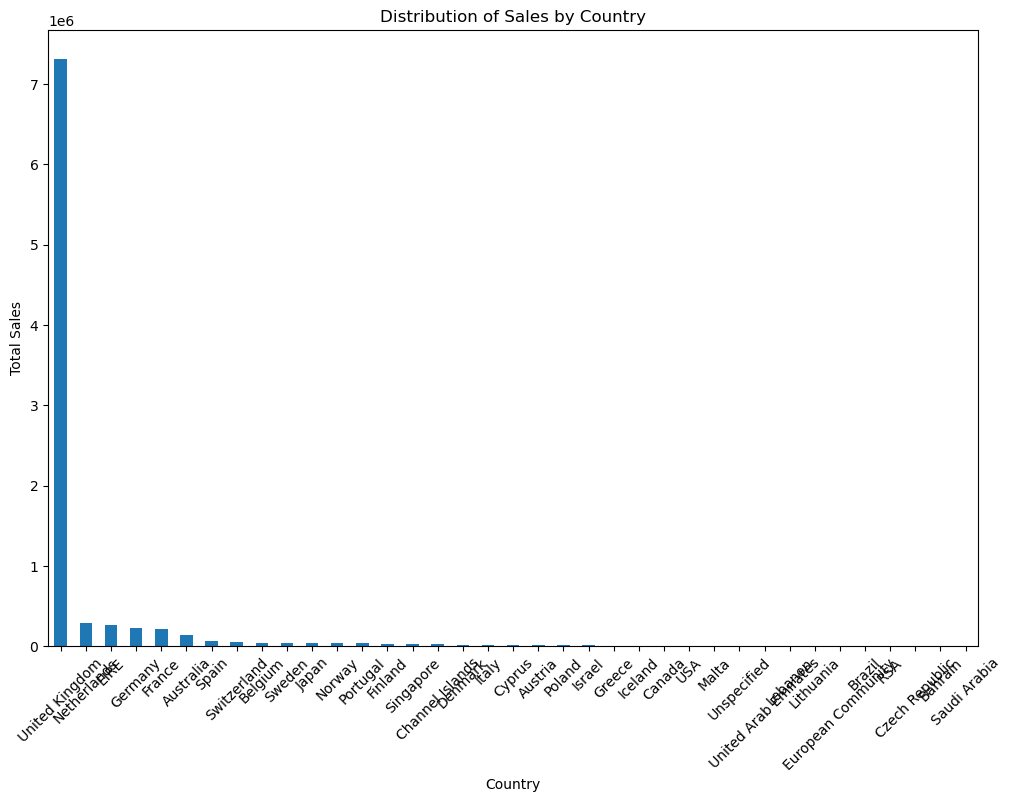

In [10]:
# Distribution of sales by country
country_sales = df.groupby('Country')['TotalSum'].sum().sort_values(ascending=False)

# Plot distribution of sales by country
plt.figure(figsize=(12, 8))
country_sales.plot(kind='bar')
plt.title('Distribution of Sales by Country')
plt.xlabel('Country')
plt.ylabel('Total Sales')
plt.xticks(rotation=45)
plt.show()

Based on this chart and this business being originally from the UK we will focus our analysis on the UK market.

In [11]:
# Filter the dataset to keep only transactions from the United Kingdom for further analyzing UK market
df_uk = df[df['Country'] == 'United Kingdom']

# Check the shape of the new DataFrame
print("Shape of DataFrame with only United Kingdom transactions:", df_uk.shape)

Shape of DataFrame with only United Kingdom transactions: (354321, 9)


In [12]:
df_uk.columns

Index(['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'UnitPrice', 'CustomerID', 'Country', 'TotalSum'],
      dtype='object')

C:\Users\ruby_\AppData\Local\Temp\ipykernel_23824\1493204616.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_uk['YearMonth'] = df_uk['InvoiceDate'].dt.to_period('M')


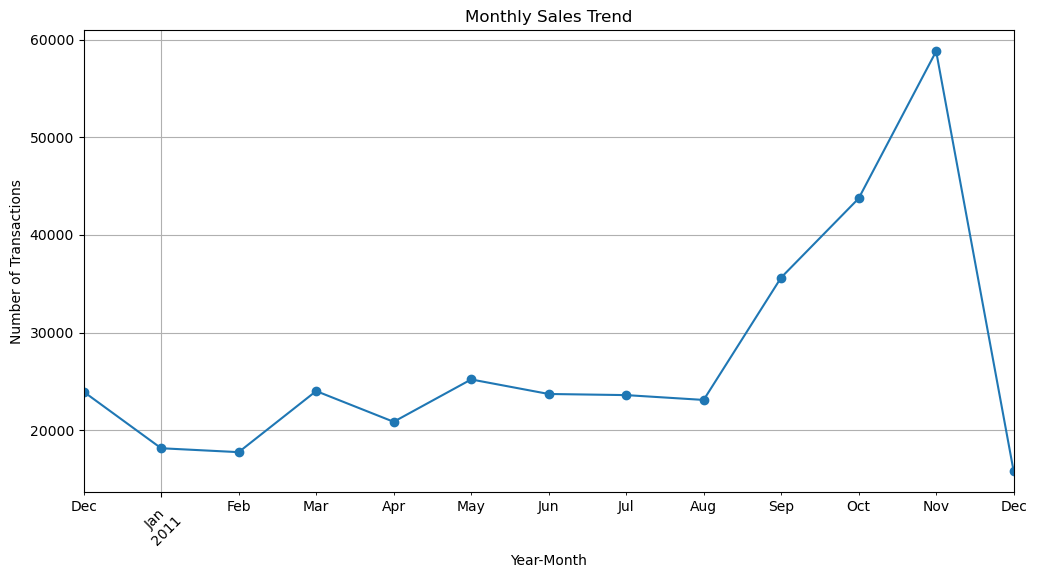

In [13]:
# Extract month and year from InvoiceDate for df_uk
df_uk['YearMonth'] = df_uk['InvoiceDate'].dt.to_period('M')

# Count the number of transactions per month for df_uk
monthly_sales = df_uk.groupby('YearMonth').size()

# Plot monthly sales trend
plt.figure(figsize=(12, 6))
monthly_sales.plot(kind='line', marker='o')
plt.title('Monthly Sales Trend')
plt.xlabel('Year-Month')
plt.ylabel('Number of Transactions')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

There is a significant spike in the number of transactions around November, where the value peaks just below 60,000 transactions. This is a stark contrast to the other months and could be considered an outlier.
The sharp decline immediately after November to a value just above 20,000 transactions in December also stands out as an unusual drop and could be another point of interest or potential outlier.
This pattern could suggest seasonal effects or specific events that drastically increased sales in November, followed by a steep decline. Further investigation into the business operations during these months would be necessary to understand the cause of these anomalies.

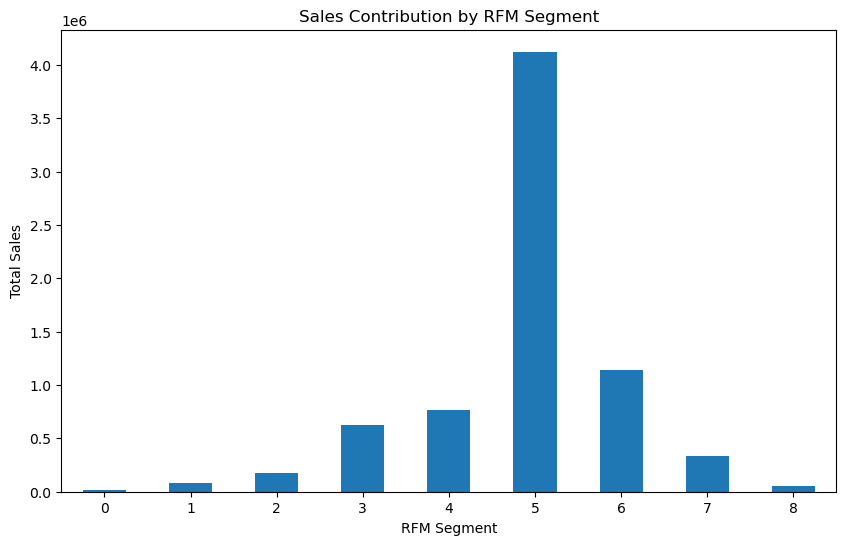

In [14]:

rfm_df = df_uk.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (snapshot_date - x.max()).days,  # Recency
    'InvoiceNo': 'nunique',                                  # Frequency
    'TotalSum': 'sum'                                        # Monetary Value
})

# Rename columns
rfm_df.rename(columns={
    'InvoiceDate': 'Recency',
    'InvoiceNo': 'Frequency',
    'TotalSum': 'MonetaryValue'
}, inplace=True)

# Segment customers based on RFM scores
# You can use quartiles or predefined segments based on business criteria
# For simplicity, let's use quartiles
rfm_df['RecencyScore'] = pd.qcut(rfm_df['Recency'], q=4, labels=False)
rfm_df['FrequencyScore'] = pd.qcut(rfm_df['Frequency'], q=4, labels=False, duplicates='drop')
rfm_df['MonetaryValueScore'] = pd.qcut(rfm_df['MonetaryValue'], q=4, labels=False)

# Calculate RFM Score by combining Recency, Frequency, and MonetaryValue scores
rfm_df['RFMScore'] = rfm_df['RecencyScore'] + rfm_df['FrequencyScore'] + rfm_df['MonetaryValueScore']

# Analyze sales contribution of each customer segment during the peak period
# For simplicity, let's focus on the RFM segments
segment_sales = rfm_df.groupby('RFMScore')['MonetaryValue'].sum()

# Plot segment sales contribution
plt.figure(figsize=(10, 6))
segment_sales.plot(kind='bar')
plt.title('Sales Contribution by RFM Segment')
plt.xlabel('RFM Segment')
plt.ylabel('Total Sales')
plt.xticks(rotation=0)
plt.show()

In [15]:
# Step 1: Filter Data for Segment 5 Customers
segment_5_customers = rfm_df[rfm_df['RFMScore'] == 5]

# Step 2: Customer Profiling
# Analyze demographics if available
# Analyze purchasing behavior
customer_profile = segment_5_customers.describe()

#Purchase Behavior Analysis
# Calculate metrics such as purchase frequency, recency, monetary value, and basket size
purchase_behavior = segment_5_customers[['Recency', 'Frequency', 'MonetaryValue']].describe()

# You can print or visualize the results of each step to analyze the findings
print("Customer Profile:")
print(customer_profile)

print("\nPurchase Behavior:")
purchase_behavior

Customer Profile:
          Recency   Frequency  MonetaryValue  RecencyScore  FrequencyScore  \
count  828.000000  828.000000     828.000000    828.000000       828.00000   
mean    58.035024    9.830918    4980.835785      0.973430         1.43599   
std     78.473310   13.253839   13843.666052      1.143519         0.71061   
min      1.000000    1.000000      70.020000      0.000000         0.00000   
25%      5.750000    3.000000    1173.712500      0.000000         1.00000   
50%     18.000000    6.000000    2093.600000      0.000000         2.00000   
75%     79.000000   12.000000    4204.672500      2.000000         2.00000   
max    372.000000  209.000000  259657.300000      3.000000         2.00000   

       MonetaryValueScore  RFMScore  
count          828.000000     828.0  
mean             2.590580       5.0  
std              0.580004       0.0  
min              0.000000       5.0  
25%              2.000000       5.0  
50%              3.000000       5.0  
75%          

,Recency,Frequency,MonetaryValue
count,828.000000,828.000000,828.000000
mean,58.035024,9.830918,4980.835785
std,78.473310,13.253839,13843.666052
min,1.000000,1.000000,70.020000
25%,5.750000,3.000000,1173.712500
50%,18.000000,6.000000,2093.600000
75%,79.000000,12.000000,4204.672500
max,372.000000,209.000000,259657.300000


Customer Profile:

Recency: The average recency value is around 58.72 days, indicating that, on average, these customers made their most recent purchase about 58 days ago.
Frequency: The average frequency value is approximately 9.83, indicating that, on average, these customers made around 9-10 purchases.
MonetaryValue: The average monetary value is about 4987.83, indicating that, on average, these customers spent around £4987.83.
RecencyScore, FrequencyScore, MonetaryValueScore: These columns show the quartile scores for recency, frequency, and monetary value, respectively, which were used to calculate the RFM score.
RFMScore: All customers in this segment have an RFM score of 5, indicating that they are high-value customers.

In [16]:
# Filter the DataFrame to include only customers in Segment 5
segment_5_customers = rfm_df[rfm_df['RFMScore'] == 5]

# Add the desired columns to the segment_5_customers DataFrame
segment_5_customers = segment_5_customers.merge(df[['CustomerID', 'Description', 'Quantity', 'InvoiceDate', 'UnitPrice']], on='CustomerID', how='left')

# Print out the customers in Segment 5 with the added columns
print("Customers in Segment 5:")
segment_5_customers

segment_5_customers.to_csv('segment_5_customers.csv', index=False)



Customers in Segment 5:


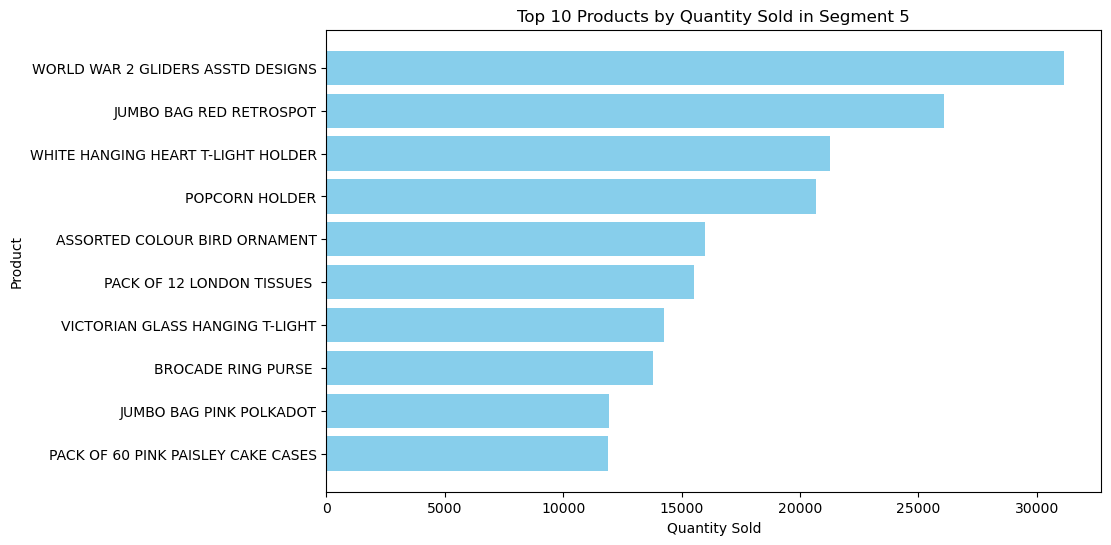

In [24]:
# Aggregate data to calculate total quantity sold for each product
product_quantity = segment_5_customers.groupby('Description')['Quantity'].sum().reset_index()

# Sort products by quantity in descending order
top_products = product_quantity.sort_values(by='Quantity', ascending=False).head(10)

# Create bar chart
plt.figure(figsize=(10, 6))
plt.barh(top_products['Description'], top_products['Quantity'], color='skyblue')
plt.xlabel('Quantity Sold')
plt.ylabel('Product')
plt.title('Top 10 Products by Quantity Sold in Segment 5')
plt.gca().invert_yaxis()  # Invert y-axis to display the product with the highest quantity at the top
plt.show()

In [55]:
segment_5_customers

,CustomerID,Recency,Frequency,MonetaryValue,RecencyScore,FrequencyScore,MonetaryValueScore,RFMScore,Description,Quantity,InvoiceDate,UnitPrice
0,12747.0,3,11,4196.01,0,2,3,5,GREEN JUICY FRUIT PHOTO FRAME,12,2010-12-05,2.55
1,12747.0,3,11,4196.01,0,2,3,5,BLUE JUICY FRUIT PHOTO FRAME,6,2010-12-05,2.55
2,12747.0,3,11,4196.01,0,2,3,5,ASSORTED COLOUR BIRD ORNAMENT,16,2010-12-05,1.69
3,12747.0,3,11,4196.01,0,2,3,5,PEARL CRYSTAL PUMPKIN T-LIGHT HLDR,24,2010-12-05,1.65
4,12747.0,3,11,4196.01,0,2,3,5,CREAM SWEETHEART LETTER RACK,6,2010-12-05,5.45
...,...,...,...,...,...,...,...,...,...,...,...,...
175060,18287.0,43,3,1837.28,1,1,3,5,LIPSTICK PEN RED,12,2011-10-12,0.42
175061,18287.0,43,3,1837.28,1,1,3,5,HAND WARMER SCOTTY DOG DESIGN,12,2011-10-12,2.10
175062,18287.0,43,3,1837.28,1,1,3,5,SET OF 3 WOODEN SLEIGH DECORATIONS,36,2011-10-28,1.25
175063,18287.0,43,3,1837.28,1,1,3,5,PAINTED METAL STAR WITH HOLLY BELLS,48,2011-10-28,0.39


## now lets start analyzing the products

In [56]:
# Count the frequency of each product
product_frequency = df_uk['Description'].value_counts()

# Display the top 10 most frequently purchased products
top_10_products = product_frequency.head(10)
print("Top 10 Most Frequently Purchased Products:")
print(top_10_products)

Top 10 Most Frequently Purchased Products:
Description
WHITE HANGING HEART T-LIGHT HOLDER    1940
JUMBO BAG RED RETROSPOT               1464
REGENCY CAKESTAND 3 TIER              1426
ASSORTED COLOUR BIRD ORNAMENT         1333
PARTY BUNTING                         1307
LUNCH BAG RED RETROSPOT               1147
LUNCH BAG  BLACK SKULL.               1049
SET OF 3 CAKE TINS PANTRY DESIGN      1020
PAPER CHAIN KIT 50'S CHRISTMAS         982
HEART OF WICKER SMALL                  952
Name: count, dtype: int64


In [57]:
# Calculate total quantity sold for each product
product_quantity_sold = df.groupby('Description')['Quantity'].sum().sort_values(ascending=False)

# Display the top 10 best-selling products by quantity sold
top_10_best_selling_products_by_quantity = product_quantity_sold.head(10)
print("Top 10 Best-Selling Products by Quantity Sold:")
print(top_10_best_selling_products_by_quantity)

Top 10 Best-Selling Products by Quantity Sold:
Description
PAPER CRAFT , LITTLE BIRDIE           80995
MEDIUM CERAMIC TOP STORAGE JAR        77916
WORLD WAR 2 GLIDERS ASSTD DESIGNS     54415
JUMBO BAG RED RETROSPOT               46181
WHITE HANGING HEART T-LIGHT HOLDER    36725
ASSORTED COLOUR BIRD ORNAMENT         35362
PACK OF 72 RETROSPOT CAKE CASES       33693
POPCORN HOLDER                        30931
RABBIT NIGHT LIGHT                    27202
MINI PAINT SET VINTAGE                26076
Name: Quantity, dtype: int64


In [58]:
# Calculate total revenue generated for each product
product_revenue = df.groupby('Description')['TotalSum'].sum().sort_values(ascending=False)

# Display the top 10 best-selling products by revenue
top_10_best_selling_products_by_revenue = product_revenue.head(10)
print("Top 10 Best-Selling Products by Revenue:")
print(top_10_best_selling_products_by_revenue)

Top 10 Best-Selling Products by Revenue:
Description
PAPER CRAFT , LITTLE BIRDIE           168469.60
REGENCY CAKESTAND 3 TIER              142592.95
WHITE HANGING HEART T-LIGHT HOLDER    100448.15
JUMBO BAG RED RETROSPOT                85220.78
MEDIUM CERAMIC TOP STORAGE JAR         81416.73
POSTAGE                                77803.96
PARTY BUNTING                          68844.33
ASSORTED COLOUR BIRD ORNAMENT          56580.34
Manual                                 53779.93
RABBIT NIGHT LIGHT                     51346.20
Name: TotalSum, dtype: float64


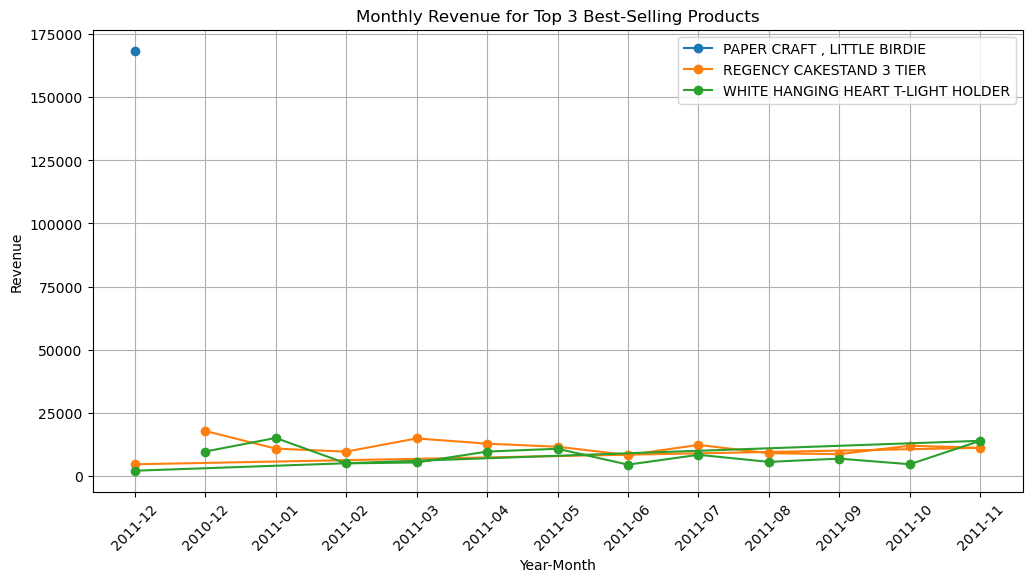

In [59]:
# Extract month and year from InvoiceDate
df['YearMonth'] = df['InvoiceDate'].dt.to_period('M')

# Sort the DataFrame by InvoiceDate
df_sorted = df.sort_values(by='InvoiceDate', ascending=True)

# Calculate total revenue per product per month
product_monthly_revenue = df_sorted.groupby(['Description', 'YearMonth'])['TotalSum'].sum()

# Select the top 3 best-selling products by revenue
top_products_revenue = [
    'PAPER CRAFT , LITTLE BIRDIE',
    'REGENCY CAKESTAND 3 TIER',
    'WHITE HANGING HEART T-LIGHT HOLDER'
]

# Plot the monthly revenue for each top product separately with markers
plt.figure(figsize=(12, 6))
for product in top_products_revenue:
    product_data = product_monthly_revenue.loc[product]
    plt.plot(product_data.index.astype(str), product_data.values, marker='o', label=product)

plt.title('Monthly Revenue for Top 3 Best-Selling Products')
plt.xlabel('Year-Month')
plt.ylabel('Revenue')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.show()

 'PAPER CRAFT , LITTLE BIRDIE' product has only one data point in December 2011, it indicates that there was only one sale recorded for that product in that specific month. This could be due to various reasons such as low demand, limited stock availability, or any other factors affecting sales.

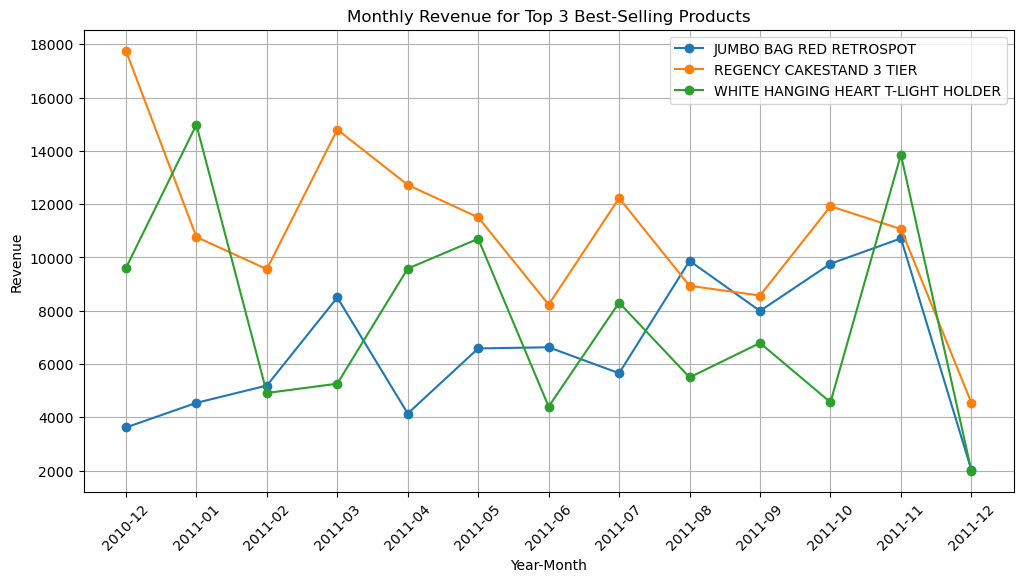

In [60]:
# Extract month and year from InvoiceDate
df['YearMonth'] = df['InvoiceDate'].dt.to_period('M')

# Sort the DataFrame by InvoiceDate
df_sorted = df.sort_values(by='InvoiceDate', ascending=True)

# Calculate total revenue per product per month
product_monthly_revenue = df_sorted.groupby(['Description', 'YearMonth'])['TotalSum'].sum()

# Select the top 3 best-selling products by revenue
top_products_revenue = [
    'JUMBO BAG RED RETROSPOT',
    'REGENCY CAKESTAND 3 TIER',
    'WHITE HANGING HEART T-LIGHT HOLDER'
]

# Plot the monthly revenue for each top product separately with markers
plt.figure(figsize=(12, 6))
for product in top_products_revenue:
    product_data = product_monthly_revenue.loc[product]
    plt.plot(product_data.index.astype(str), product_data.values, marker='o', label=product)

plt.title('Monthly Revenue for Top 3 Best-Selling Products')
plt.xlabel('Year-Month')
plt.ylabel('Revenue')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.show()

## Analysis:

All three products show some seasonality, with revenue peaks that appear to align with certain times of the year, possibly indicating higher sales during specific seasons or months.
The 'JUMBO BAG RED RETROSPOT' and 'REGENCY CAKESTAND 3 TIER' show more volatility in their revenue, with sharper increases and decreases, while the 'WHITE HANGING HEART T-LIGHT HOLDER' shows a more steady growth over the year.
The months of April, July, and November seem to be significant for all products, which could suggest seasonal events or holidays that drive sales during these periods.
December shows a sharp decline for all products, which could indicate stock issues, a change in consumer behavior, or other external factors affecting sales.
This chart could be used to make business decisions such as inventory management, marketing strategies, and sales forecasting. It would be beneficial to compare this data with other factors like marketing campaigns, price changes, or market trends to gain a more comprehensive understanding of the factors influencing revenue.